The accuracy of the model without dropout:  0.891
The accuracy of the model with dropout:  0.92


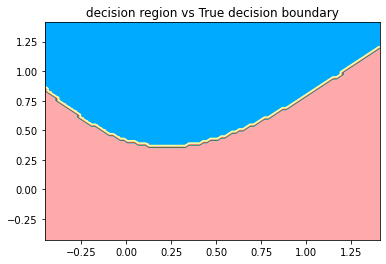

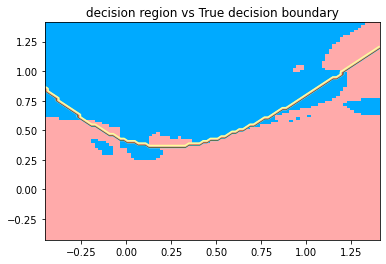

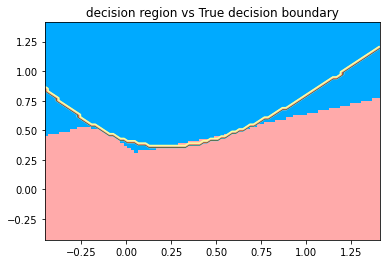

In [24]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader
from torch import optim

# The function for plotting the diagram

def plot_decision_regions_3class(data_set, model=None):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    newdata = np.c_[xx.ravel(), yy.ravel()]
    
    Z = data_set.multi_dim_poly(newdata).flatten()
    f = np.zeros(Z.shape)
    f[Z > 0] = 1
    f = f.reshape(xx.shape)
    if model != None:
        model.eval()
        XX = torch.Tensor(newdata)
        _, yhat = torch.max(model(XX), 1)
        yhat = yhat.numpy().reshape(xx.shape)
        plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
    else:
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
        plt.pcolormesh(xx, yy, f, cmap=cmap_light) 

    plt.title("decision region vs True decision boundary")
    plt.show()

# Create data class for creating dataset object

class Data(Dataset):
    
    # Constructor
    def __init__(self, N_SAMPLES=1000, noise_std=0.1, train=True):
        a = np.matrix([-1, 1, 2, 1, 1, -3, 1]).T
        self.x = np.matrix(np.random.rand(N_SAMPLES, 2))
        self.f = np.array(a[0] + (self.x) * a[1:3] + np.multiply(self.x[:, 0], self.x[:, 1]) * a[4] + np.multiply(self.x, self.x) * a[5:7]).flatten()
        self.a = a
       
        self.y = np.zeros(N_SAMPLES)
        self.y[self.f > 0] = 1
        self.y = torch.from_numpy(self.y).type(torch.LongTensor)
        self.x = torch.from_numpy(self.x).type(torch.FloatTensor)
        self.x = self.x + noise_std * torch.randn(self.x.size())
        self.f = torch.from_numpy(self.f)
        self.a = a
        if train == True:
            torch.manual_seed(1)
            self.x = self.x + noise_std * torch.randn(self.x.size())
            torch.manual_seed(0)
        
    # Getter        
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot(self):
        X = data_set.x.numpy()
        y = data_set.y.numpy()
        h = .02
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max() 
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = data_set.multi_dim_poly(np.c_[xx.ravel(), yy.ravel()]).flatten()
        f = np.zeros(Z.shape)
        f[Z > 0] = 1
        f = f.reshape(xx.shape)
        
        plt.title('True decision boundary  and sample points with noise ')
        plt.plot(self.x[self.y == 0, 0].numpy(), self.x[self.y == 0,1].numpy(), 'bo', label='y=0') 
        plt.plot(self.x[self.y == 1, 0].numpy(), self.x[self.y == 1,1].numpy(), 'ro', label='y=1')
        plt.contour(xx, yy, f,cmap=plt.cm.Paired)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.legend()
    
    # Make a multidimension ploynomial function
    def multi_dim_poly(self, x):
        x = np.matrix(x)
        out = np.array(self.a[0] + (x) * self.a[1:3] + np.multiply(x[:, 0], x[:, 1]) * self.a[4] + np.multiply(x, x) * self.a[5:7])
        out = np.array(out)
        return out



def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x), 1)
    return (yhat == data_set.y).numpy().mean()

train_data = Data(noise_std=0.1,train=True)
torch.manual_seed(0)
valid_data = Data(noise_std=0.1,train=False)


class NN(nn.Module):
  def __init__(self,layers,p=0):
    super(NN,self).__init__()
    self.drop = nn.Dropout(p=p)
    self.layers_ = nn.ModuleList()
    for in_,out_ in zip(layers,layers[1:]):
      self.layers_.append(nn.Linear(in_,out_))

  def forward(self,x):
    L = len(self.layers_)
    for l,linear_ in zip(range(L),self.layers_):
      if (l<L-1):
        x = F.relu(self.drop(linear_(x)))
      else:
        x= linear_(x)
    return x

mylayers = [2,450,450,2]
model = NN(mylayers)
model_dropout = NN(mylayers,0.5)

model_dropout.train()

optimiser = optim.Adam(model.parameters(),lr=0.01)
optimiser_D = optim.Adam(model_dropout.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()

LOSS = {}
LOSS['training data no dropout'] = []
LOSS['validation data no dropout'] = []
LOSS['training data dropout'] = []
LOSS['validation data dropout'] = []

epochs = 500
def train(epochs):
  for epoch in range (epochs):
    yhat = model(train_data.x)
    yhat_D = model_dropout(train_data.x)
    loss = criterion(yhat,train_data.y)
    loss_d = criterion(yhat_D,train_data.y)

    LOSS['training data no dropout'].append(loss)
    LOSS['training data dropout'].append(loss_d)
    LOSS['validation data no dropout'].append(criterion(model(train_data.x),train_data.y))
    model_dropout.eval()
    LOSS['validation data dropout'].append(criterion(model_dropout(train_data.x),train_data.y))
    model_dropout.train()

    optimiser.zero_grad()
    optimiser_D.zero_grad()

    loss.backward()
    loss_d.backward()

    optimiser.step()
    optimiser_D.step()


train(epochs)
model_dropout.eval()

print("The accuracy of the model without dropout: ", accuracy(model,valid_data))
print("The accuracy of the model with dropout: ", accuracy(model_dropout,valid_data))

plot_decision_regions_3class(train_data)
plot_decision_regions_3class(train_data, model)
plot_decision_regions_3class(train_data, model_dropout)
